```{contents}
```
## **Fallback Node in LangGraph**

A **Fallback Node** in LangGraph is a **fault-tolerance mechanism** that provides an alternative execution path when a primary node fails, times out, or produces an invalid result.
It is a fundamental building block for **production-grade reliability** in LLM workflows.

---

### **1. Why Fallback Nodes Are Needed**

LLM systems are **inherently unreliable**:

* APIs fail
* Models hallucinate
* Tools crash
* Rate limits occur
* Responses violate constraints

A Fallback Node prevents **entire workflow failure** by **gracefully degrading** the system.

---

### **2. Conceptual Model**

```
        ┌─────────────┐
        │ Primary Node│
        └──────┬──────┘
               │
         (Failure / Invalid)
               │
        ┌──────▼──────┐
        │ Fallback    │
        │ Node        │
        └─────────────┘
```

The graph **never crashes**; it reroutes.

---

### **3. When a Fallback Is Triggered**

Fallback execution occurs when:

| Trigger          | Description              |
| ---------------- | ------------------------ |
| Exception        | Node raises error        |
| Timeout          | Execution exceeds limit  |
| Invalid Output   | Output fails validation  |
| Quality Failure  | Hallucination / unsafe   |
| Resource Failure | API down, quota exceeded |

---

### **4. Implementation Pattern**

LangGraph does not expose a built-in `FallbackNode` class.
Fallback is implemented using **error handling + conditional routing**.

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    text: str
    result: str
    error: bool

def primary_llm(state):
    if "fail" in state["text"]:
        raise ValueError("LLM failure")
    return {"result": state["text"].upper(), "error": False}

def fallback_llm(state):
    return {"result": "DEFAULT RESPONSE", "error": False}

def safe_primary(state):
    try:
        return primary_llm(state)
    except:
        return {"error": True}

def router(state):
    if state["error"]:
        return "fallback"
    return END

builder = StateGraph(State)

builder.add_node("primary", safe_primary)
builder.add_node("fallback", fallback_llm)

builder.set_entry_point("primary")

builder.add_conditional_edges("primary", router, {
    "fallback": "fallback",
    END: END
})

builder.add_edge("fallback", END)

graph = builder.compile()
```

---

### **6. Advanced Fallback Variants**

| Variant            | Description          |
| ------------------ | -------------------- |
| Model Fallback     | Switch to backup LLM |
| Tool Fallback      | Alternate API        |
| Data Fallback      | Cached response      |
| Human Fallback     | Ask human            |
| Heuristic Fallback | Rule-based logic     |
| Degraded Mode      | Partial output       |

---

### **7. Model Fallback Example**

```python
def llm_primary(state):
    return {"result": call_gpt4(state)}

def llm_backup(state):
    return {"result": call_gpt35(state)}
```

On failure, the system **downgrades gracefully**.

---

### **8. Production Guarantees from Fallback Nodes**

| Guarantee            | Outcome                  |
| -------------------- | ------------------------ |
| High availability    | System never fully fails |
| Graceful degradation | Lower quality, not crash |
| User trust           | Predictable behavior     |
| Cost control         | Avoid runaway retries    |
| Compliance           | Safe handling of errors  |

---

### **9. Best Practices**

* Always log fallback usage
* Track fallback frequency
* Prefer deterministic fallback outputs
* Combine with retry + timeout
* Never allow silent failure

---

### **10. Mental Model**

> **Primary path for quality
> Fallback path for survival**

A robust LangGraph system is not one that **never fails**,
but one that **never collapses when failure occurs**.


### Demonstration

In [1]:
from typing import TypedDict, Optional

class State(TypedDict):
    query: str
    result: Optional[str]
    error: bool
    retries: int

def primary_llm(state: State):
    if "fail" in state["query"]:
        raise RuntimeError("Primary model failure")
    return {"result": f"Primary answer: {state['query']}", "error": False}

def fallback_llm(state: State):
    return {"result": f"Fallback answer: {state['query']}", "error": False}

MAX_RETRIES = 2

def safe_primary(state: State):
    try:
        return primary_llm(state)
    except:
        if state["retries"] < MAX_RETRIES:
            return {"error": True, "retries": state["retries"] + 1}
        return {"error": True}

def route(state: State):
    if not state["error"]:
        return "end"
    if state["retries"] < MAX_RETRIES:
        return "retry"
    return "fallback"


In [2]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("primary", safe_primary)
builder.add_node("fallback", fallback_llm)

builder.set_entry_point("primary")

builder.add_conditional_edges("primary", route, {
    "retry": "primary",
    "fallback": "fallback",
    "end": END
})

builder.add_edge("fallback", END)

graph = builder.compile()


In [3]:
# Case 1: Success
print(graph.invoke({"query": "hello", "result": None, "error": False, "retries": 0}))

# Case 2: Failure → Retry → Fallback
print(graph.invoke({"query": "fail now", "result": None, "error": False, "retries": 0}))


{'query': 'hello', 'result': 'Primary answer: hello', 'error': False, 'retries': 0}
{'query': 'fail now', 'result': 'Fallback answer: fail now', 'error': False, 'retries': 2}


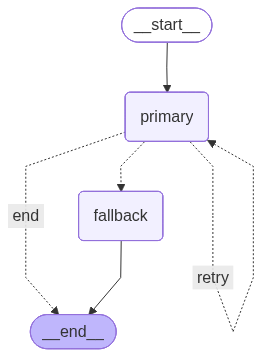

In [4]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())